### Preliminaries

In [1]:
%matplotlib inline
import os
import sys
curr_path = os.getcwd()
gerkin_path = os.path.split(curr_path)[0]
olfaction_prediction_path = os.path.split(gerkin_path)[0]
sys.path.append(olfaction_prediction_path)
import opc_python
import numpy as np
import matplotlib.pyplot as plt
from opc_python.utils import loading, scoring
from opc_python.gerkin import dream,fit1,fit2,params

In [2]:
# Get all Chemical IDs and located the data directory.  
all_CIDs = sorted(loading.get_CIDs('training')+loading.get_CIDs('leaderboard')+loading.get_CIDs('testset'))
mdx = dream.get_molecular_data(['dragon'],all_CIDs)

There are now 4870 total features.


### Create matrices

In [18]:
# Create the feature matrices from the feature dicts.  
X_training,good1,good2,means,stds,imputer = dream.make_X(mdx,"training")
X_all,good1,good2,means,stds,imputer = dream.make_X(mdx,['training','leaderboard'],good1=good1,good2=good2,means=means,stds=stds)
X_testset_int,good1,good2,means,stds,imputer = dream.make_X(mdx,['testset'],target_dilution=-3,good1=good1,good2=good2,means=means,stds=stds)
X_testset_other,good1,good2,means,stds,imputer = dream.make_X(mdx,['testset'],target_dilution='high',good1=good1,good2=good2,means=means,stds=stds)

The X matrix now has shape (676x3033) molecules by non-NaN good molecular descriptors
The X matrix now has shape (814x3033) molecules by non-NaN good molecular descriptors
The X matrix now has shape (69x3033) molecules by non-NaN good molecular descriptors
The X matrix now has shape (69x3033) molecules by non-NaN good molecular descriptors


In [4]:
# Create descriptor matrices for the combined training and leaderboard sets.  
# One is done with median imputation, and the other by masking missing values.  
Y_all_imp,imputer = dream.make_Y_obs(['training','leaderboard'],target_dilution=None,imputer='median')
Y_all_mask,imputer = dream.make_Y_obs(['training','leaderboard'],target_dilution=None,imputer='mask')

The Y['mean_std'] matrix now has shape (814x42) molecules by 2 x perceptual descriptors
The Y['subject'] dict now has 49 matrices of shape (814x21) molecules by perceptual descriptors, one for each subject
The Y['mean_std'] matrix now has shape (814x42) molecules by 2 x perceptual descriptors
The Y['subject'] dict now has 49 matrices of shape (814x21) molecules by perceptual descriptors, one for each subject


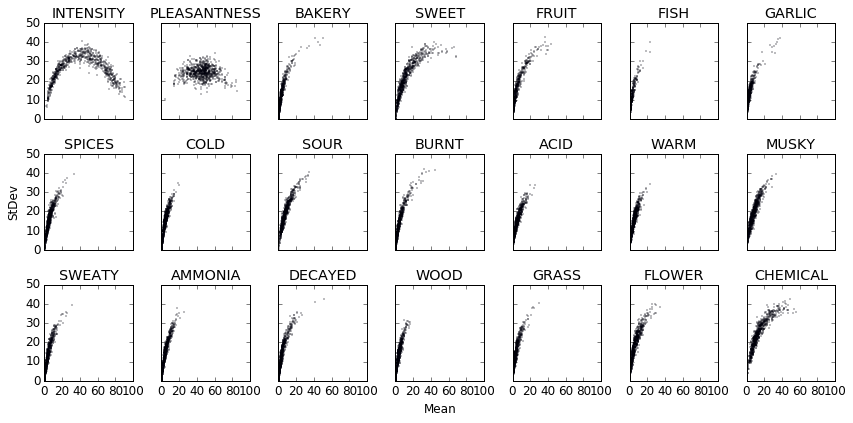

In [5]:
perceptual_headers, perceptual_obs_data = loading.load_perceptual_data('training')
descriptors = [x.split('/')[1 if i==1 else 0] for i,x in enumerate(perceptual_headers[6:])]
trans_params = params.get_trans_params(Y_all_mask,descriptors,plot=True)

In [6]:
# Load optimal parameters (obtained from extensive cross-validation).
def get_params(i):
    return {col:params.best[col][i] for col in range(42)}
use_et,max_features,max_depth,min_samples_leaf,regularize,use_mask = [get_params(i) for i in range(6)]
trans_weight = regularize.copy()
for i in range(21):
    trans_weight[i] = regularize[i+21]

### Fitting and Generating Submission Files for challenge 2

In [7]:
import pandas
# Compare to the results in the pre-computed "PredInsights_Fdiffodor.txt" file.  
df_static = pandas.read_csv('../../data/PredInsights_Fdiffodor.txt', 
                     delimiter='\t')
# First 5 rows of loaded data.  
bad_features = list(df_static[:10]['Feature'])
molecular_headers, molecular_data = loading.load_molecular_data()
all_features = molecular_headers[1:]
bad_feature_indices = [all_features.index(bf) for bf in bad_features]

In [19]:
# Create the feature matrices from the feature dicts.  
X_training_nobad,good1,good2,means,stds,imputer = dream.make_X(mdx,"training",bad=bad_feature_indices)
X_all_nobad,good1,good2,means,stds,imputer = dream.make_X(mdx,['training','leaderboard'],bad=bad_feature_indices,good1=good1,good2=good2,means=means,stds=stds)
X_testset_int_nobad,good1,good2,means,stds,imputer = dream.make_X(mdx,['testset'],target_dilution=-3,bad=bad_feature_indices,good1=good1,good2=good2,means=means,stds=stds)
X_testset_other_nobad,good1,good2,means,stds,imputer = dream.make_X(mdx,['testset'],target_dilution='high',bad=bad_feature_indices,good1=good1,good2=good2,means=means,stds=stds)

The X matrix now has shape (676x3023) molecules by non-NaN good molecular descriptors
The X matrix now has shape (814x3023) molecules by non-NaN good molecular descriptors
The X matrix now has shape (69x3023) molecules by non-NaN good molecular descriptors
The X matrix now has shape (69x3023) molecules by non-NaN good molecular descriptors


In [23]:
# Fit all available data. 
# Ignoring warning that arises if too few trees are used.  
# Ignore intensity score which is based on within-sample validation, 
# due to use of ExtraTreesClassifier.
n_estimators = 500
rfcs_original,score,rs = fit2.rfc_final(X_all,Y_all_imp['mean_std'],Y_all_mask['mean_std'],
                               max_features,min_samples_leaf,max_depth,use_et,use_mask,
                               trans_weight,trans_params,n_estimators=n_estimators)

97.62% [------------------------------------------------- ]For subchallenge 2:
	Score = 14.84
	int_mean = 1.000
	int_sigma = 0.938
	ple_mean = 0.970
	ple_sigma = 0.814
	dec_mean = 0.827
	dec_sigma = 0.753


In [24]:
rfcs_nobad,score,rs = fit2.rfc_final(X_all_nobad,Y_all_imp['mean_std'],Y_all_mask['mean_std'],
                               max_features,min_samples_leaf,max_depth,use_et,use_mask,
                               trans_weight,trans_params,n_estimators=n_estimators)

97.62% [------------------------------------------------- ]For subchallenge 2:
	Score = 14.83
	int_mean = 1.000
	int_sigma = 0.938
	ple_mean = 0.970
	ple_sigma = 0.811
	dec_mean = 0.827
	dec_sigma = 0.753


In [25]:
# Make challenge 2 testset prediction files from the models.  
loading.make_prediction_files(rfcs_original,X_testset_int,X_testset_other,'testset',2,name='testset_original',write=True,
                              trans_weight=trans_weight,trans_params=trans_params)
# Make challenge 2 testset prediction files from the models.  
loading.make_prediction_files(rfcs_nobad,X_testset_int_nobad,X_testset_other_nobad,'testset',2,name='testset_nobad',write=True,
                              trans_weight=trans_weight,trans_params=trans_params)

Wrote to file with suffix "testset_original"
Wrote to file with suffix "testset_nobad"


{'mean_std': array([[ 26.31028571,  41.66765306,   1.97744133, ...,   9.66531296,
          10.2269768 ,  32.29698348],
        [ 32.50567347,  43.94055102,   1.94580543, ...,   7.96138804,
          10.96945871,  22.15976922],
        [ 52.26995918,  31.39144898,   1.82057673, ...,   8.42230048,
          10.81356251,  23.47447486],
        ..., 
        [ 50.13081633,  50.40791837,   2.330001  , ...,  22.05498234,
          18.25746968,  21.24853987],
        [ 29.50093878,  48.36395918,   3.08480541, ...,  13.18338178,
          17.04129937,  21.66641991],
        [ 21.47955102,  48.38491837,   1.92706433, ...,  17.25419275,
          23.83026183,  32.40226438]]), 'subject': {}}

In [31]:
testset_CIDs = loading.get_CIDs('testset')
testset_CIDs.index(5862) # L-cysteine

11

In [43]:
print('INTENSITY: %.1f' % rfcs_original[0].predict(X_testset_int[11,:]))
for i in range(1,21):
    print('%s: %.1f' % (descriptors[i],
                        rfcs_original[i].predict(X_testset_other[11,:])))

INTENSITY: 28.3
PLEASANTNESS: 30.1
BAKERY: 3.2
SWEET: 6.2
FRUIT: 1.6
FISH: 4.0
GARLIC: 9.5
SPICES: 5.5
COLD: 2.8
SOUR: 11.3
BURNT: 10.4
ACID: 4.8
WARM: 5.5
MUSKY: 9.0
SWEATY: 6.6
AMMONIA: 5.6
DECAYED: 9.7
WOOD: 2.2
GRASS: 1.6
FLOWER: 1.9
CHEMICAL: 10.0


In [42]:
descriptors

['INTENSITY',
 'PLEASANTNESS',
 'BAKERY',
 'SWEET',
 'FRUIT',
 'FISH',
 'GARLIC',
 'SPICES',
 'COLD',
 'SOUR',
 'BURNT',
 'ACID',
 'WARM',
 'MUSKY',
 'SWEATY',
 'AMMONIA',
 'DECAYED',
 'WOOD',
 'GRASS',
 'FLOWER',
 'CHEMICAL']